# Chapter 4: Acceralation of word2vec

The problem of word2vec which implemented previous chapter is that it would be slow if the courpus is huge. So, we need to improve word2vec.

## 4.1 word2vec improvement : Embedding class

forward method of Embedding class just extract the word vector which associated  with current id from the weight matrix.


In [9]:
import numpy as np

W = np.arange(21).reshape(7, 3)

print(W)
print(W[2])

idx = np.array([1, 0, 2])
print(idx)
print(W[idx])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[6 7 8]
[1 0 2]
[[3 4 5]
 [0 1 2]
 [6 7 8]]


In [10]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        # np.add.at(dW, self.idx, dout)
        # return None
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
        return None

In [11]:
tdW = np.random.randn(7, 3)

print(tdW)

tdW[...] = 0

print(tdW)

[[-0.01178028  1.30896743 -1.29881108]
 [-0.86799128  0.69779318 -0.25252134]
 [ 0.35435235  0.9358486   0.56632695]
 [-0.54266719 -0.1894857  -0.29677768]
 [-1.11300384 -2.04874329  0.11396044]
 [ 1.12562939 -0.29764231  0.41837521]
 [-0.93302057  0.06212079  0.62596364]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


## 4.2 word2vec improvement : Negative sampling

### 4.2.1 calculation problem after middle layer

When the corpus size is huge, calculation takes time in following process.

- the product of the neurons of the hidden layer and the weight matrix
- calculation of Softmax layer

For example, softmax is shown as following assuming that the corpus size is 100,000.

$$
y = \frac{\exp(x_i)}{\sum_j^{1000000} \exp(x_j)}
$$

### 4.2.2 Negative sampling

To reduce the calculation problem, we use negative sampling in which we randomly select negative samples from the corpus.

### 4.2.3 Sigmoid function and Cross entropy error

Sigmoid function and Cross entropy error are shown as following.

Sigmoid:
$$
y = \frac{1}{1 + e^{-x}}
$$

Cross entropy error:
$$
L = -(t \log y + (1 - t) \log (1 - y))
$$

![../images/4.2.3.png](./fig/4_2_3.drawio.svg)

### 4.2.4 From multiclass classification to binary classification

Here is a diagram of the CBOW (Continuous Bag of Words) model for multi-class classification:
![img](./fig/4_2_4.drawio.svg)

In order to reduce the calculation problem, we use CBOW model for binary classification as shown below:
![img](./fig/4_2_4_2.drawio.svg)


In [12]:
# embedding dot class
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [13]:
import numpy as np
W = np.arange(21).reshape(7, 3)
h = np.arange(9).reshape(3, 3)
idx = np.array([0, 3, 1])

embed = Embedding(W)
target_W = embed.forward(idx)
out = np.sum(target_W * h, axis=1)

print(out.reshape(out.shape[0], 1))
print(target_W)
print(h)

[[  5]
 [122]
 [ 86]]
[[ 0  1  2]
 [ 9 10 11]
 [ 3  4  5]]
[[0 1 2]
 [3 4 5]
 [6 7 8]]


### 4.2.5 Negative sampling

Negative sampling is learning correct words with some sample incorrect words.
Normally 5 ~ 10 negtive samples are randomly selected from the corpus.
This is the reason to be called Negative sampling.

### 4.2.6 Sampling method of Negative sampling

when we use negative sampling, we use appearance probability of the word in the corpus.

$$
P'(W_i) = \frac{P(W_i)^{0.75}}{\sum_j^{n} P(W_j)^{0.75}}
$$

In [14]:
import numpy as np

np.random.choice(10)

words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
print(np.random.choice(words))
print(np.random.choice(words))

print(np.random.choice(words, size=3))
print(np.random.choice(words, size=3, replace=False))

# use probability
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))
print(np.random.choice(words, p=p))

p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

you
hello
['.' 'goodbye' '.']
['hello' 'I' 'goodbye']
.
hello
you
hello
I
[0.64196878 0.33150408 0.02652714]


In [15]:
# 4.2.6 Negative sampling
GPU = False

import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [16]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
counts = collections.Counter()

for word_id in corpus:
    counts[word_id] += 1

In [17]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)

print(negative_sample)


[[3 0]
 [2 1]
 [2 3]]


### 4.2.7 Implementation of Negative sampling

In [18]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

In [19]:
# Class NegativeSamplingLoss
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 1.正例の評価
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 2.負例の評価
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
            
        return dh




## 4.3 Learning of improved word2vec

### 4.3.1 implementation of CBOW model


In [20]:
import sys
import numpy as np

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


### 4.3.2 Learning of CBOW


| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 1[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 1[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 2[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 2[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 3[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 3[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 4[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 4[s] | loss 3.38
| epoch 1 |  iter 201 / 9295 | time 5[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 5[s] | loss 3.17
| epoch 1 |  iter 241 / 9295 | time 6[s] | loss 3.07
| epoch 1 |  iter 261 / 9295 | time 7[s] | loss 3.00
| epoch 1 |  iter 281 / 9295 | time 7[s] | loss 2.96
| epoch 1 |  iter 301 / 9295 | time 8[s] | loss 2.91
| epoch 1 |  iter 321 / 9295 | time 8[s] | loss 2.87
| epoch 1 |  iter 341 / 9295 | time 9[s] | loss 2.82
| epoch 1 |  iter 361 / 9295 | time 9[s] | loss 2.82

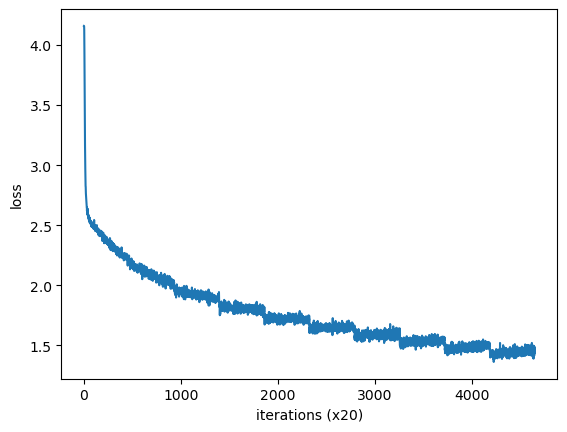

In [21]:
# Learning of CBOW
GPU = False

import sys
# sys.path.append("../org/deep-learning-from-scratch-2/")

# #check if there is common directory in the path
# print(sys.path)
import os
sys.path.append(os.path.abspath("../.org/deep-learning-from-scratch-2/"))


import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# Hyper parameters
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# Load corpus
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if GPU:
    contexts = to_gpu(contexts)
    target = to_gpu(target)

# Create model
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# Training
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# save data
word_vecs = model.word_vecs
if GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


### 4.3.3 Testing of CBOW model

In [22]:
import sys
sys.path.append("./.org/deep-learning-from-scratch-2/")

from common.util import most_similar, analogy

In [27]:
def cos_similarity(x, y, eps=1e-8):
    '''コサイン類似度の算出

    :param x: ベクトル
    :param y: ベクトル
    :param eps: ”0割り”防止のための微小値
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


In [28]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''類似単語の検索

    :param query: クエリ（テキスト）
    :param word_to_id: 単語から単語IDへのディクショナリ
    :param id_to_word: 単語IDから単語へのディクショナリ
    :param word_matrix: 単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されていることを想定する
    :param top: 上位何位まで表示するか
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


In [31]:
import sys
import pickle


pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.728515625
 i: 0.68994140625
 they: 0.63427734375
 your: 0.63037109375
 anybody: 0.59423828125

[query] year
 month: 0.82275390625
 summer: 0.77197265625
 week: 0.75390625
 spring: 0.73583984375
 decade: 0.71240234375

[query] car
 luxury: 0.6015625
 truck: 0.568359375
 auto: 0.56201171875
 cars: 0.556640625
 window: 0.55126953125

[query] toyota
 nissan: 0.638671875
 seita: 0.60986328125
 honda: 0.603515625
 engines: 0.603515625
 mazda: 0.59716796875


In [24]:
from common.util import cos_similarity

print(word_to_id["you"])
print(word_vecs[(word_to_id["you"]),:])

print(word_to_id["i"])
print(word_vecs[(word_to_id["i"]),:])

cos_similarity(word_vecs[(word_to_id["you"]),:], word_vecs[(word_to_id["year"]),:])

316
[-1.044   -0.3945   0.883   -1.73    -0.9126   0.8047  -1.329    0.6294
 -1.3      1.408   -0.5806  -0.6064  -1.314   -1.183    0.6724  -0.2683
  0.3557   0.5156   1.366   -0.1018  -0.2869   0.68    -0.5205   1.714
  0.3945  -0.978   -0.5327   0.09265  0.5425  -0.2776   1.043    0.07733
 -0.6294   0.565    0.3198   0.769   -0.4795   1.19     0.495   -0.697
 -0.6914   0.453   -0.4026  -0.272   -0.6426   0.81    -0.513    0.71
 -0.2336  -0.802   -0.492   -1.799    1.638   -0.971   -0.558    0.37
  1.005   -1.203    0.2253  -1.216    1.153   -0.563   -1.6      0.5244
 -0.543   -0.9863  -0.993    0.2399  -0.548   -0.09094 -0.4695   1.764
 -0.604    0.2878  -0.4575   1.059   -1.181   -0.78     1.067   -0.812
 -0.68     0.0392   0.539   -1.1455  -1.3      0.4485  -1.446   -0.1744
 -0.02475  0.4907   0.947   -0.4497  -0.2944   0.5405  -1.058    1.905
  0.8105   1.403   -1.329   -0.3347 ]
1040
[-1.35      0.0669    0.1097   -1.394    -0.34     -0.0858   -1.538
  0.845    -0.735     1.662  

-0.02428

In [25]:
from common.util import analogy

analogy('man', 'king', 'woman', word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)


[analogy] man:king = woman:?
 horse: 4.546875
 ton: 3.994140625
 kid: 3.984375
 pages: 3.94140625
 artist: 3.787109375

[analogy] take:took = go:?
 eurodollars: 5.2109375
 came: 4.390625
 were: 4.3671875
 're: 4.3125
 went: 4.30859375

[analogy] car:cars = child:?
 a.m: 6.37890625
 rape: 5.953125
 children: 5.25
 incest: 4.984375
 adults: 4.8046875

[analogy] good:better = bad:?
 rather: 5.4140625
 more: 5.4140625
 less: 5.40625
 greater: 4.39453125
 faster: 3.94921875


## 4.4 Remained theme of CBOW

### 4.4.1 Application sample of word2vec

trained model of word2vec can be used to solve the analogy problem.
単語を固定長ベクトルに変換することで自然言語の様々なタスク(感情分析など)に使用することができる。

### 4.4.2 Evaluation method of word vector

実際のアプリケーションでは複数のシステムを組み合わせて作られる。

- 単語の分散表現の作成
- 特定の問題に対して分類を行う

2段階の機械学習を同時にチューニングするには多くの時間がかかるため、
分散表現の良さをアプリケーションと切り離して評価するのが一般的である。



# 4.5 Summary
Learned about acceleration of word2vec and improvement of CBOW model with implementing Embedding layer and negative sampling.  
Embedding layer extracts the word vector associated with current id from the weight matrix instead of the whole matrix of word vectors.  
Negative sampling is used to reduce the calculation problem since it calculates softmax layer with randomly selected negative samples.  

